In [158]:
import os
import random 
import pandas as pd
import numpy as np
import pytz
from statsmodels.tsa.seasonal import STL
from matplotlib import figure, pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [159]:
## These are my default settings for plots

plt.rcParams["font.family"] = "Times New Roman"
plt.rc("xtick",labelsize=12)
plt.rc("ytick",labelsize=12)
plt.rcParams["figure.figsize"] = (20,8)
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'xtick.labelsize': 18})
plt.rcParams.update({'ytick.labelsize': 18})

# Functions

In [160]:
# Function for reproducible results
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

In [161]:
# Forecast Accuracy Metric
def MAPE(df,column_actual,column_predicted):
    mask1 = df[column_actual] != 0
    df = df[mask1]
    y_true, y_pred = np.array(df[column_actual].values), np.array(df[column_predicted].values)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

In [162]:
def RMSE(df,column_actual,column_predicted):
    mask1 = df[column_actual] != 0
    df = df[mask1]
    rmse = mean_squared_error(df[column_actual], df[column_predicted], squared=False)
    return rmse

In [163]:
# This function creates the population matrix from which we will draw randomly blocks of the size=24 (default).
# Each row represents one block of the size 24
# Matrix shape: # number of blocks (281) x block size (24)

def build_matrix(df,size=24):
    n = len(df_training)
    block_size = size
    maximum_number_of_blocks = n-block_size+1
    population_matrix = np.zeros(shape=(block_size,maximum_number_of_blocks), dtype=float)
    for i in range(0,maximum_number_of_blocks):
        population_matrix[:,i] = df['residuals'][i:i+block_size].values
    population_matrix = population_matrix.T
    return population_matrix

In [164]:
# This function draws randomly from the population matrix and returns the desired number of 
# bootstrapped residuals time series

def bootstrapping_residuals(df_train,number_of_bootstrapped_series=10,size=24):
    set_seed(100)
    n = len(df_train)
    block_size = size
    maximum_number_of_blocks = n-block_size+1
    number_of_drafts = int(n/block_size)

    bootstrapped_single_time_series = []
    bootstrapped_collection_time_series = []
    sample = 0
    population_matrix = build_matrix(df_train)
    # number_of_drafts = # of Drafts for each bootstrapped time series
    # number_of_bootstrapped_series = # of series that will be bootstrapped
    for j in range(0,number_of_bootstrapped_series):
        bootstrapped_single_time_series = []
        for i in range(0,number_of_drafts+2):
        # inner loop to draft blocks for time series j
        # here we draft each draft i a random block (size 24) from the population matrix
            random_series_draft = np.random.randint(0,maximum_number_of_blocks)
            sample = population_matrix[random_series_draft,:]
            # After the last iteration in the inner loop 
            # bootstrapped_single_time_series is a bootstrapped time series that 
            bootstrapped_single_time_series.append(sample)
        bootstrapped_collection_time_series.append(bootstrapped_single_time_series)
    return bootstrapped_collection_time_series

In [165]:
def build_bootstrapped_df(bootstrapped_series,df_training_data,size=24):
    set_seed(100)
    temp_series = []
    block_size = size
    for i in range(0,len(bootstrapped_series)):
        temp_series.append(np.concatenate(bootstrapped_series[i]))

        # discard random number of values between 0 and block_size - 1 at the beginning
        number_of_elements_to_remove = np.random.randint(0,block_size-1)
        temp_series[i] = temp_series[i][number_of_elements_to_remove:]

        # Discard all elements after the last element of the original training series
        if len(temp_series[i]) > len(df_training_data):
            temp_series[i] = temp_series[i][:len(df_training_data)]   
        temp_series[i] = temp_series[i].reshape(-1,1)
    #    temp_series[i] = temp_series[i] + df_training['trend'].values + df_training['seasonality'].values

    # Create dataframe
    df = pd.DataFrame(np.array(temp_series).tolist())
    df = df.T
    for i in range(0,len(df.columns)):
        df[i] = df[i].str[0] 
    df.columns = ['bootstrapped_series_' + str(col) for col in df.columns]
    df.index = df_training_data.index
    df.asfreq('MS')
    return df

# Data Exploration

In [166]:
# Read the date and rename the column for convenience reasons
df = pd.read_csv('01 Kaggle/Alcohol_Sales.csv',sep=',')
df.rename({'S4248SM144NCEN':'sales'},axis=1,inplace = True)

In [167]:
df['DATE'] = pd.to_datetime(df['DATE'],format='%Y-%m-%d')

In [168]:
df.index = df['DATE']
df = df.drop('DATE',axis=1)

In [169]:
df.asfreq('MS')

,sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221
...,...
2018-09-01,12396
2018-10-01,13914
2018-11-01,14174


In [170]:
#delet last data point to have a consistent dataset
df = df[:len(df)-1]

<AxesSubplot:xlabel='DATE'>

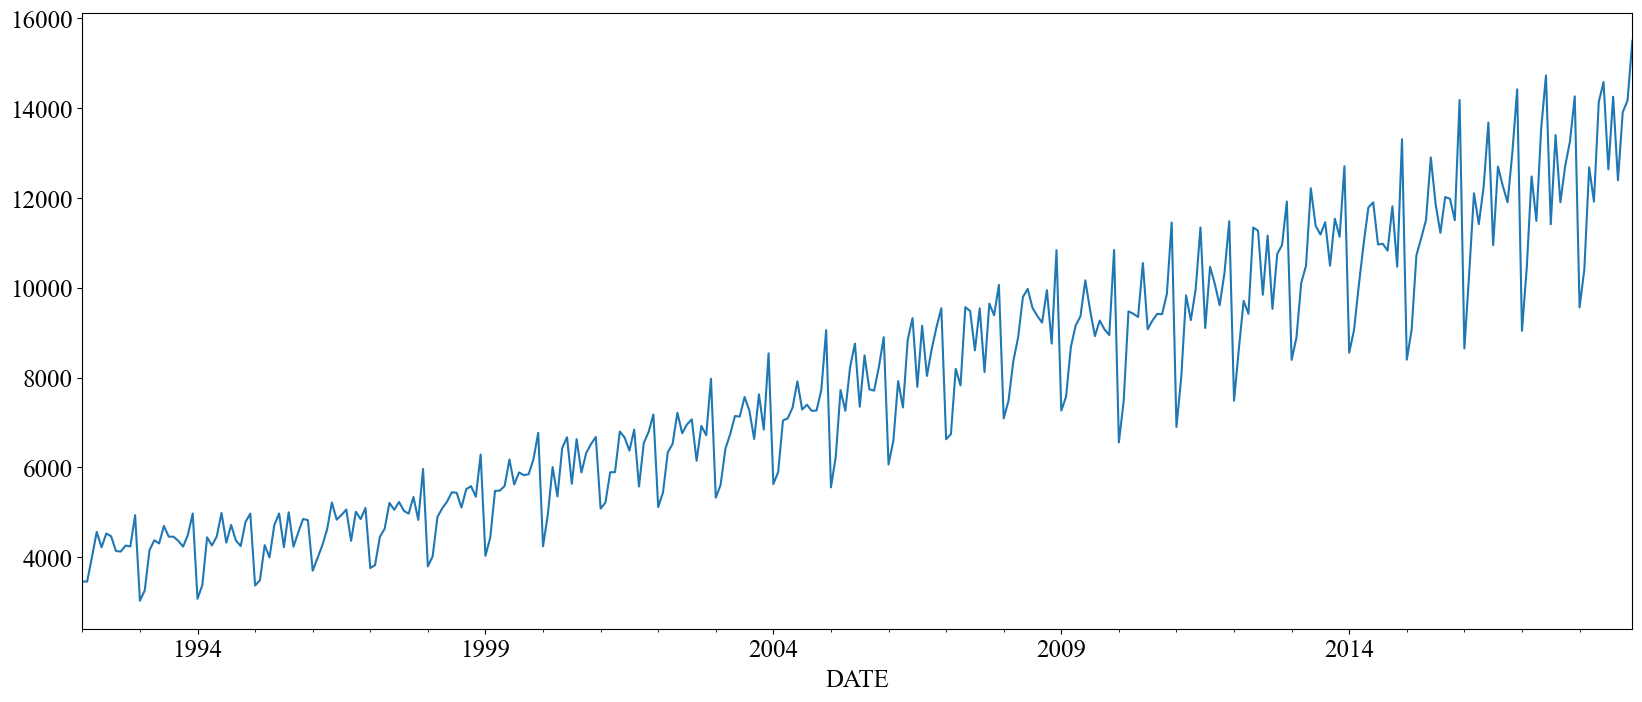

In [171]:
df['sales'].plot()

<AxesSubplot:xlabel='DATE'>

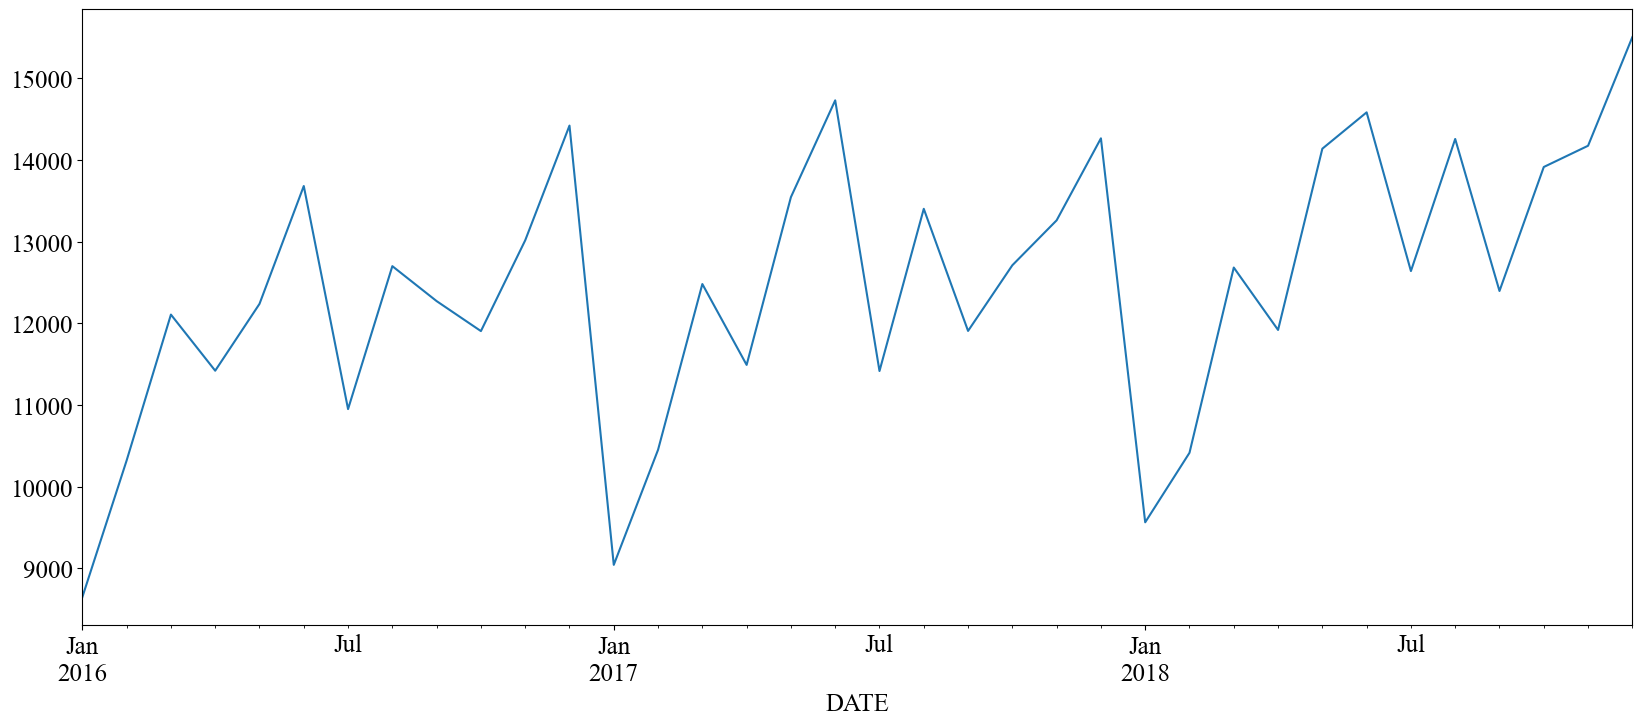

In [172]:
df[-36:]['sales'].plot()

<AxesSubplot:xlabel='DATE'>

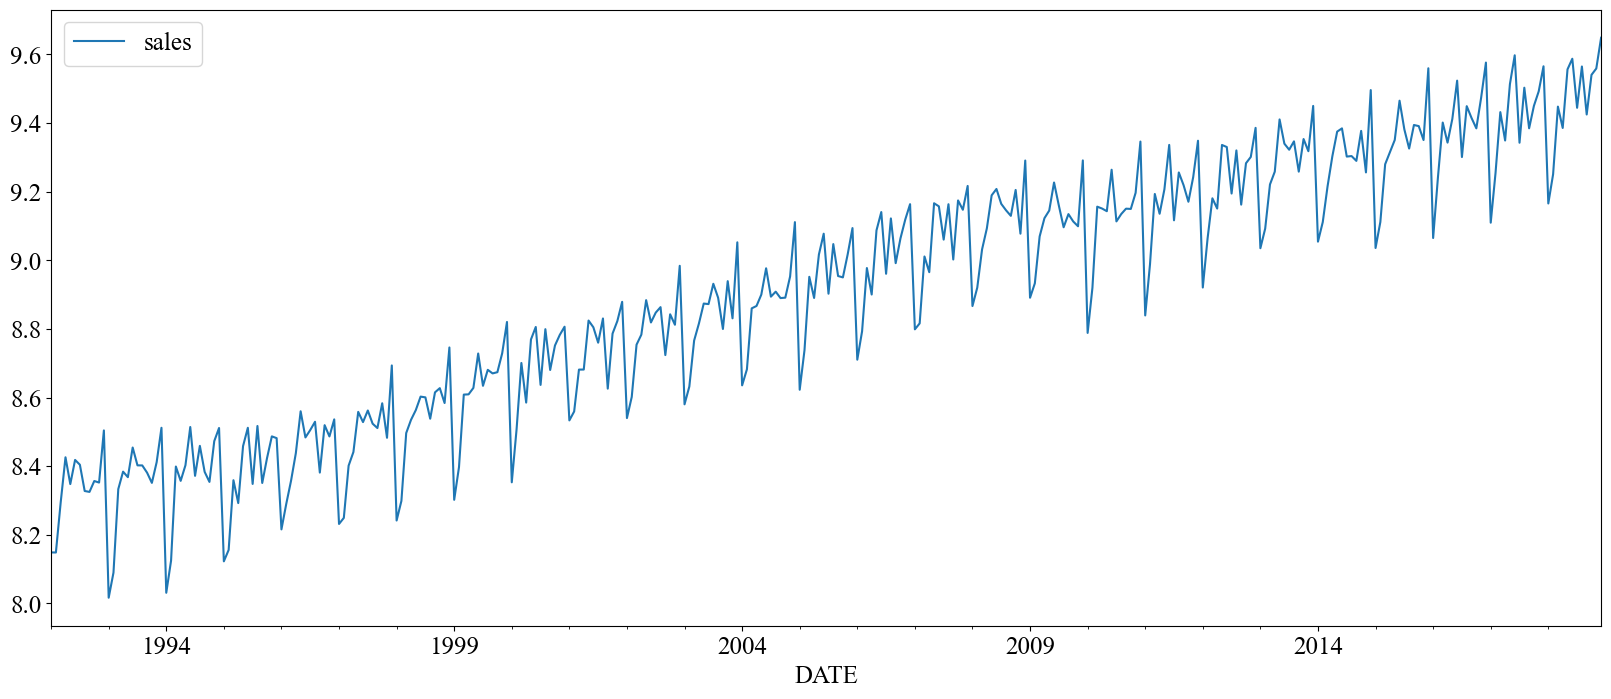

In [173]:
# Both mean and variance are not perfectly constant but it should be 'good enough' 
# Additional test could be applied (ADF, KPSS, CH, etc.) but for illustration this should be fine

np.log(df).plot()

# Baseline model

In [174]:
# split the data into training and test data
training_index = len(df)-12
df_training = df[:training_index].copy()
df_training = np.log(df_training)
df_test= df[training_index:].copy()

In [175]:
model = ETSModel(df_training['sales'],error='add',trend='add',seasonal='add',seasonal_periods=12)
model = model.fit()
y_hat = model.forecast(steps=12)
# Important: calculate the exponential of all predictions to transform the forecast back to the original scale
y_hat = np.exp(y_hat)
df_test['ETS_baseline'] = y_hat

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.30985D-01    |proj g|=  9.88789D-01

At iterate    1    f= -8.64106D-01    |proj g|=  1.12699D+01

At iterate    2    f= -1.18670D+00    |proj g|=  5.82147D+00

At iterate    3    f= -1.29859D+00    |proj g|=  2.59158D+00

At iterate    4    f= -1.35378D+00    |proj g|=  1.94922D+00

At iterate    5    f= -1.38336D+00    |proj g|=  1.30028D+00

At iterate    6    f= -1.45182D+00    |proj g|=  3.16371D-01

At iterate    7    f= -1.47747D+00    |proj g|=  2.30122D-01

At iterate    8    f= -1.49485D+00    |proj g|=  9.97083D-01

At iterate    9    f= -1.50008D+00    |proj g|=  6.84034D-01

At iterate   10    f= -1.50617D+00    |proj g|=  9.95182D-01

At iterate   11    f= -1.51149D+00    |proj g|=  1.49759D-01

At iterate   12    f= -1.51695D+00    |proj g|=  7.79108D-01

At iterate   13    f= -1.5

/Users/niclaspopovic/opt/anaconda3/envs/boosting/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [176]:
# Compute MAPE of baseline model
mape_baseline = round(MAPE(df_test,'sales','ETS_baseline'),2)
print(f'MAPE: {mape_baseline}')
rmse_baseline = round(RMSE(df_test,'sales','ETS_baseline'),2)
print(f'RMSE: {rmse_baseline}')

MAPE: 3.01
RMSE: 476.58


<AxesSubplot:xlabel='DATE'>

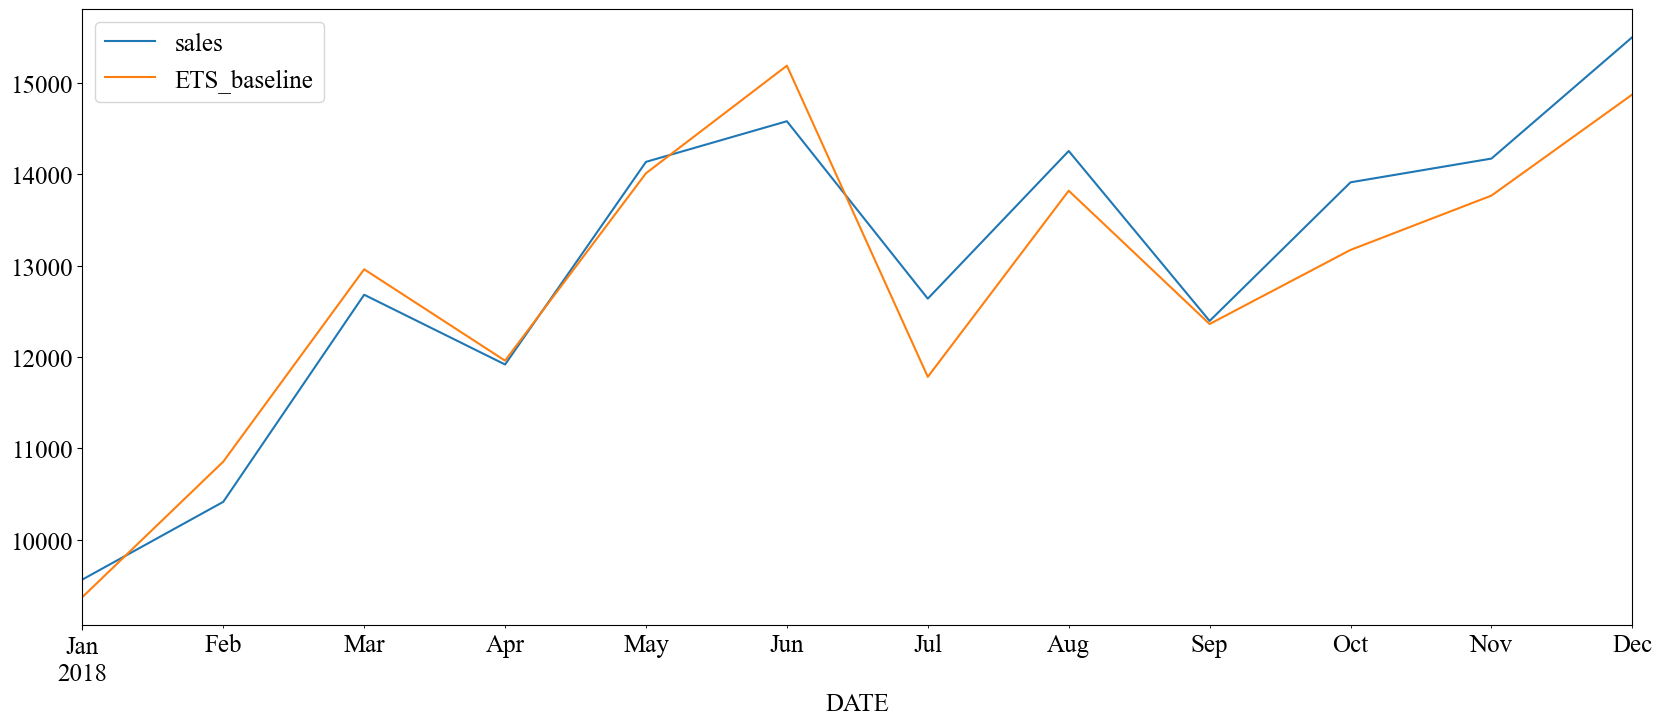

In [177]:
# Plot actual demand vs predicitons 
df_test.plot()

# Bootstrapping

In [178]:
# Here we compute the residuals of the original training data series 
res = STL(df_training['sales'],robust=True).fit()
df_training['residuals'] = res.resid
df_training['trend'] = res.trend
df_training['seasonality'] = res.seasonal

In [179]:
bootstrapped_master_time_series = bootstrapping_residuals(df_training,number_of_bootstrapped_series=20)

In [154]:
df_bootstrapped = build_bootstrapped_df(bootstrapped_master_time_series,df_training)

## Make Predictions for each Time Series

In [155]:
predictions = []
for i in range (0, 20):
    # Add trend & seasonality to bootstrapped series
    df_bootstrapped[f'bootstrapped_series_{i}'] += df_training['trend'] + df_training['seasonality']
    model = ETSModel(df_bootstrapped[f'bootstrapped_series_{i}'],error='add',trend='add',seasonal='add',seasonal_periods=12,freq='MS')
    model = model.fit()
    y_hat = model.forecast(steps=12)
    y_hat = np.exp(y_hat)
    predictions.append(y_hat)
df_test['ETS_bootstrapped'] = np.mean(predictions,axis=0)

# You can ignore the warning regar

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.99549D-01    |proj g|=  9.88789D-01

At iterate    1    f= -7.62082D-01    |proj g|=  1.08669D+01

At iterate    2    f= -1.26648D+00    |proj g|=  3.24613D+00

At iterate    3    f= -1.34132D+00    |proj g|=  1.25614D+00

At iterate    4    f= -1.45527D+00    |proj g|=  2.46913D+00

At iterate    5    f= -1.50895D+00    |proj g|=  1.81016D+00

At iterate    6    f= -1.56327D+00    |proj g|=  3.27553D-01

At iterate    7    f= -1.57465D+00    |proj g|=  1.12099D+00

At iterate    8    f= -1.58497D+00    |proj g|=  4.14104D-01

At iterate    9    f= -1.59490D+00    |proj g|=  3.05834D-01

At iterate   10    f= -1.60113D+00    |proj g|=  2.82953D-01

At iterate   11    f= -1.62819D+00    |proj g|=  1.75768D+00

At iterate   12    f= -1.64178D+00    |proj g|=  5.32851D+00

At iterate   13    f= -1.6

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.91376D-01    |proj g|=  9.88789D-01

At iterate    1    f= -7.40021D-01    |proj g|=  1.06500D+01

At iterate    2    f= -1.23082D+00    |proj g|=  2.96092D+00

At iterate    3    f= -1.29594D+00    |proj g|=  1.14026D+00

At iterate    4    f= -1.39448D+00    |proj g|=  2.26063D+00

At iterate    5    f= -1.44704D+00    |proj g|=  1.85729D+00

At iterate    6    f= -1.52441D+00    |proj g|=  1.48938D+00

At iterate    7    f= -1.53637D+00    |proj g|=  5.44115D-01

At iterate    8    f= -1.54202D+00    |proj g|=  2.21489D-01

At iterate    9    f= -1.54764D+00    |proj g|=  8.81592D-01

At iterate   10    f= -1.54992D+00    |proj g|=  3.28766D-01

At iterate   11    f= -1.55111D+00    |proj g|=  1.16174D+00

At iterate   12    f= -1.55359D+00    |proj g|=  1.65115D-01

At iterate   13    f= -1.5

At iterate    7    f= -1.49436D+00    |proj g|=  3.80174D-01

At iterate    8    f= -1.50739D+00    |proj g|=  6.67885D-01

At iterate    9    f= -1.52050D+00    |proj g|=  2.26533D-01

At iterate   10    f= -1.52927D+00    |proj g|=  8.23357D-01

At iterate   11    f= -1.53131D+00    |proj g|=  1.28322D+00

At iterate   12    f= -1.53332D+00    |proj g|=  3.72455D-01

At iterate   13    f= -1.53584D+00    |proj g|=  1.31228D-01

At iterate   14    f= -1.54245D+00    |proj g|=  1.35995D+00

At iterate   15    f= -1.54863D+00    |proj g|=  1.40556D+00

At iterate   16    f= -1.56633D+00    |proj g|=  1.39620D+00

At iterate   17    f= -1.58931D+00    |proj g|=  6.67863D-01

At iterate   18    f= -1.60830D+00    |proj g|=  2.29992D+00

At iterate   19    f= -1.62308D+00    |proj g|=  4.70812D+00

At iterate   20    f= -1.62475D+00    |proj g|=  2.03299D+00

At iterate   21    f= -1.63160D+00    |proj g|=  9.95255D-01

At iterate   22    f= -1.63791D+00    |proj g|=  1.70879D-01

At itera

At iterate   50    f= -1.85478D+00    |proj g|=  2.47227D+00

At iterate   51    f= -1.85547D+00    |proj g|=  4.54345D-01

At iterate   52    f= -1.85561D+00    |proj g|=  2.94092D-01

At iterate   53    f= -1.85562D+00    |proj g|=  9.05176D-02

At iterate   54    f= -1.85564D+00    |proj g|=  2.83261D-01

At iterate   55    f= -1.85566D+00    |proj g|=  3.35731D-01

At iterate   56    f= -1.85569D+00    |proj g|=  1.60413D+00

At iterate   57    f= -1.85576D+00    |proj g|=  5.35797D-01

At iterate   58    f= -1.85579D+00    |proj g|=  1.33454D-01

At iterate   59    f= -1.85581D+00    |proj g|=  6.48153D-02

At iterate   60    f= -1.85582D+00    |proj g|=  3.11973D-02

At iterate   61    f= -1.85583D+00    |proj g|=  1.08235D-02

At iterate   62    f= -1.85583D+00    |proj g|=  8.49327D-02

At iterate   63    f= -1.85583D+00    |proj g|=  4.84663D-02

At iterate   64    f= -1.85583D+00    |proj g|=  1.94186D-02

At iterate   65    f= -1.85583D+00    |proj g|=  3.86758D-02

At itera


At iterate   27    f= -1.95631D+00    |proj g|=  2.84779D+00

At iterate   28    f= -1.96117D+00    |proj g|=  3.88900D+00

At iterate   29    f= -1.96547D+00    |proj g|=  1.65706D+00

At iterate   30    f= -1.96631D+00    |proj g|=  1.61872D+00

At iterate   31    f= -1.96673D+00    |proj g|=  1.01745D+00

At iterate   32    f= -1.96754D+00    |proj g|=  2.41741D-01

At iterate   33    f= -1.96825D+00    |proj g|=  6.77715D-01

At iterate   34    f= -1.96938D+00    |proj g|=  3.54972D+00

At iterate   35    f= -1.97046D+00    |proj g|=  1.42150D+00

At iterate   36    f= -1.97108D+00    |proj g|=  1.44281D-01

At iterate   37    f= -1.97131D+00    |proj g|=  4.03461D-01

At iterate   38    f= -1.97136D+00    |proj g|=  2.85780D-01

At iterate   39    f= -1.97139D+00    |proj g|=  1.23075D+00

At iterate   40    f= -1.97145D+00    |proj g|=  7.49894D-01

At iterate   41    f= -1.97154D+00    |proj g|=  8.96511D-02

At iterate   42    f= -1.97157D+00    |proj g|=  3.95816D-01

At iter

At iterate    1    f= -8.28930D-01    |proj g|=  1.14134D+01

At iterate    2    f= -1.27834D+00    |proj g|=  4.73497D+00

At iterate    3    f= -1.37002D+00    |proj g|=  1.84973D+00

At iterate    4    f= -1.45028D+00    |proj g|=  2.41264D+00

At iterate    5    f= -1.49728D+00    |proj g|=  1.94825D+00

At iterate    6    f= -1.57014D+00    |proj g|=  4.38204D-01

At iterate    7    f= -1.58844D+00    |proj g|=  9.67855D-01

At iterate    8    f= -1.59583D+00    |proj g|=  4.85728D-01

At iterate    9    f= -1.60548D+00    |proj g|=  3.86677D-01

At iterate   10    f= -1.61148D+00    |proj g|=  3.30823D-01

At iterate   11    f= -1.61948D+00    |proj g|=  1.07177D+00

At iterate   12    f= -1.62436D+00    |proj g|=  2.52297D+00

At iterate   13    f= -1.63523D+00    |proj g|=  5.39545D-01

At iterate   14    f= -1.65349D+00    |proj g|=  1.46520D+00

At iterate   15    f= -1.66009D+00    |proj g|=  7.81184D-01

At iterate   16    f= -1.66281D+00    |proj g|=  2.48549D-01

At itera


At iterate    7    f= -1.46417D+00    |proj g|=  1.75887D-01

At iterate    8    f= -1.46757D+00    |proj g|=  3.43993D-01

At iterate    9    f= -1.47487D+00    |proj g|=  4.17113D-01

At iterate   10    f= -1.49509D+00    |proj g|=  4.03893D+00

At iterate   11    f= -1.49770D+00    |proj g|=  5.42976D-01

At iterate   12    f= -1.50146D+00    |proj g|=  4.04986D-01

At iterate   13    f= -1.50894D+00    |proj g|=  1.76885D+00

At iterate   14    f= -1.51188D+00    |proj g|=  8.05892D-01

At iterate   15    f= -1.51438D+00    |proj g|=  5.82496D+00

At iterate   16    f= -1.51596D+00    |proj g|=  1.11721D+00

At iterate   17    f= -1.51839D+00    |proj g|=  3.59409D+00

At iterate   18    f= -1.52012D+00    |proj g|=  4.84406D+00

At iterate   19    f= -1.52246D+00    |proj g|=  3.35430D+00

At iterate   20    f= -1.52538D+00    |proj g|=  7.47103D-01

At iterate   21    f= -1.52759D+00    |proj g|=  4.26305D-01

At iterate   22    f= -1.52876D+00    |proj g|=  5.38732D-01

At iter


At iterate    1    f= -7.58479D-01    |proj g|=  1.06737D+01

At iterate    2    f= -1.20683D+00    |proj g|=  3.72533D+00

At iterate    3    f= -1.28648D+00    |proj g|=  1.61104D+00

At iterate    4    f= -1.38905D+00    |proj g|=  2.70235D+00

At iterate    5    f= -1.44906D+00    |proj g|=  2.19478D+00

At iterate    6    f= -1.54715D+00    |proj g|=  2.96393D-01

At iterate    7    f= -1.56427D+00    |proj g|=  8.12552D-01

At iterate    8    f= -1.57348D+00    |proj g|=  5.89734D-01

At iterate    9    f= -1.59297D+00    |proj g|=  3.13373D-01

At iterate   10    f= -1.60716D+00    |proj g|=  1.26169D+00

At iterate   11    f= -1.61133D+00    |proj g|=  1.21164D+00

At iterate   12    f= -1.61296D+00    |proj g|=  2.00714D+00

At iterate   13    f= -1.61973D+00    |proj g|=  3.13675D-01

At iterate   14    f= -1.62342D+00    |proj g|=  5.83478D-01

At iterate   15    f= -1.63305D+00    |proj g|=  1.41955D+00

At iterate   16    f= -1.64100D+00    |proj g|=  8.06377D-01

At iter

At iterate   41    f= -1.79566D+00    |proj g|=  3.28880D+00

At iterate   42    f= -1.80557D+00    |proj g|=  7.17088D+00

At iterate   43    f= -1.81220D+00    |proj g|=  6.66909D+00

At iterate   44    f= -1.81279D+00    |proj g|=  3.90045D+00

At iterate   45    f= -1.81422D+00    |proj g|=  2.27885D-01

At iterate   46    f= -1.81489D+00    |proj g|=  4.02906D-01

At iterate   47    f= -1.81490D+00    |proj g|=  1.84693D-01

At iterate   48    f= -1.81492D+00    |proj g|=  3.19725D-01

At iterate   49    f= -1.81494D+00    |proj g|=  2.72911D-01

At iterate   50    f= -1.81494D+00    |proj g|=  5.01097D-02

At iterate   51    f= -1.81495D+00    |proj g|=  2.88332D-01

At iterate   52    f= -1.81497D+00    |proj g|=  5.13782D-01

At iterate   53    f= -1.81501D+00    |proj g|=  7.54972D-01

At iterate   54    f= -1.81510D+00    |proj g|=  9.90325D-01

At iterate   55    f= -1.81531D+00    |proj g|=  9.31881D-01

At iterate   56    f= -1.81531D+00    |proj g|=  1.37151D+00

At itera

 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.94039D-01    |proj g|=  9.88789D-01

At iterate    1    f= -7.34046D-01    |proj g|=  1.05056D+01

At iterate    2    f= -1.20455D+00    |proj g|=  2.95164D+00

At iterate    3    f= -1.26566D+00    |proj g|=  1.18937D+00

At iterate    4    f= -1.35113D+00    |proj g|=  2.02354D+00

At iterate    5    f= -1.39493D+00    |proj g|=  1.69761D+00

At iterate    6    f= -1.45844D+00    |proj g|=  8.17995D-01

At iterate    7    f= -1.46890D+00    |proj g|=  1.03998D+00

At iterate    8    f= -1.48132D+00    |proj g|=  8.42971D-01

At iterate    9    f= -1.49371D+00    |proj g|=  4.04172D-01

At iterate   10    f= -1.50133D+00    |proj g|=  2.59718D+00

At iterate   11    f= -1.50343D+00    |proj g|=  1.19537D+00

At iterate   12    f= -1.50759D+00    |proj g|=  2.40651D-01

At iterate   13    f= -1.51027D+00    |proj g|=  6.79800D-01

At iterate   14    f= -1.51494D+00    |

In [156]:
# Results of the bootstrapping approach
mape_bootstrapped = round(MAPE(df_test,'sales','ETS_bootstrapped'),2)
print(f'MAPE: {mape_bootstrapped}')
rmse_bootstrapped = round(RMSE(df_test,'sales','ETS_bootstrapped'),2)
print(f'RMSE: {rmse_bootstrapped}')

MAPE: 2.8
RMSE: 424.0


<AxesSubplot:xlabel='DATE'>

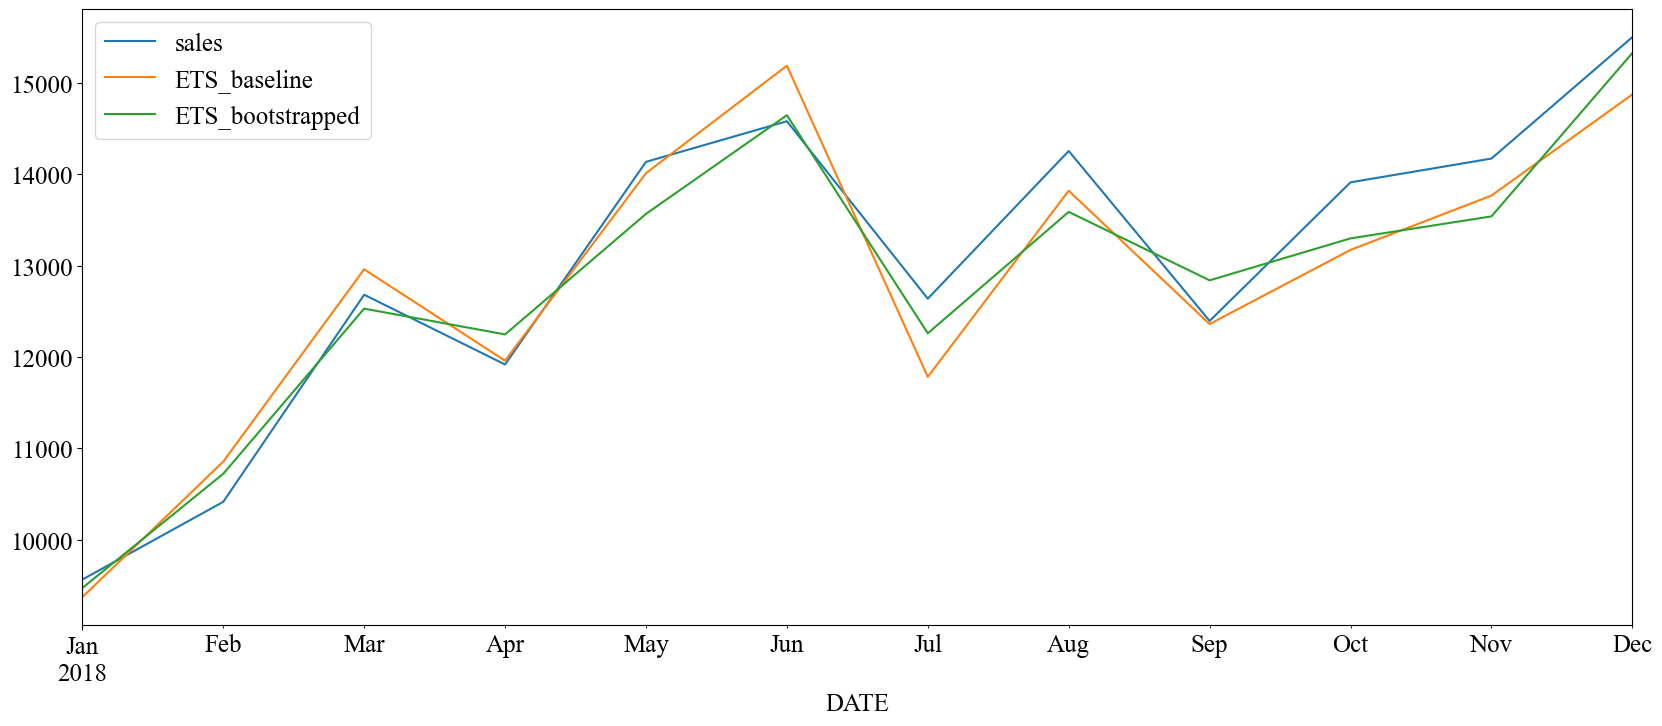

In [157]:
df_test.plot()